In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import warnings
warnings.filterwarnings('ignore')

## 3.1 MNIST

In [10]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

In [11]:
X, y = mnist['data'], mnist['target']

In [12]:
X.shape

(70000, 784)

In [13]:
y.shape

(70000,)

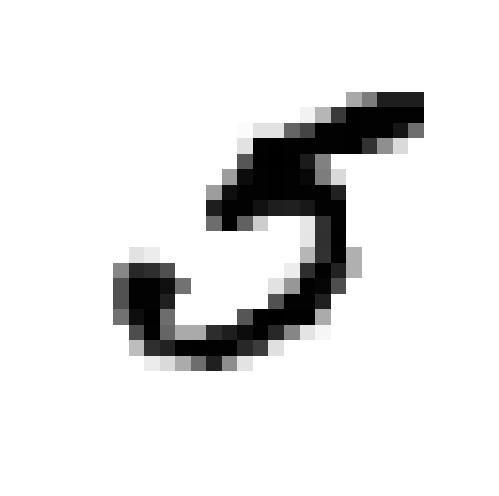

In [14]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = plt.cm.binary,
           interpolation="nearest")
plt.axis("off");

In [15]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [16]:
np.random.seed(42)
shuffle_index = np.random.permutation(60000)

In [17]:
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

훈련 샘플의 순서에 민감해서 많은 비슷한 샘플이 연이어 나타나면 성능이 저하됩니다.<br>
데이터셋을 섞으면 이런 문제를 해결 할 수 있습니다.

## 3.2 이진분류기 훈련

5만 식별해보겠습니다. '5-감지기'는 5와 5아님 두개의 클래스를 구분 할 수 있는 이진분류기의 한 예입니다.

In [10]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

SGDClassifier를 사용하여 확률적 경사하강법(stochastic gradient descent) 분류기로 시작해보겠습니다.<br>
이 분류기는 매우 큰 데이터넷을 효율적으로 처리하는 장점이 있습니다.<br>

In [11]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [12]:
sgd_clf.predict([some_digit])

array([ True])

## 3.3 성능 측정

### 3.3.1 교차 검증을 사용한 정확도 측정

In [13]:
from sklearn.model_selection import StratifiedKFold # 클래스별 비율이 유지되도록 폴드를 만들기 위함
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    #clone_clf = SGDClassifier(max_iter=5, random_state=42)
    
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9502
0.96565
0.96495


In [14]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')
#모델, 데이터, 레이블

array([0.9502 , 0.96565, 0.96495])

95%의 정확도를 나타냅니다.

In [15]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [16]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.909  , 0.90715, 0.9128 ])

5의 데이터가 전체의 10%이기때문에 5아님 이라 예측하게 되더라도 정확도는 90%를 나타냅니다.<br>
이런 예제는 정확도를 분류기의 성능 측정 지표로 선호하지 않는 이유입니다.<br>
특히 불균형한 데이터셋을 다룰때 그렇습니다.

In [17]:
np.bincount(y_train.astype(int))

array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949])

### 3.3.2 오차행렬

분류기의 성능을 평가하는 더 좋은 방법은 오차행렬(confusion matrix)를 조사하는 것입니다.<br>
cross_val_predict() 함수는 k-fold 교차 검증을 수행하지만 평가 점수를 반환하지 않고 각 테스트 폴드에서 얻은 예측값을 반환합니다.<br>

In [18]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [19]:
y_train_5

array([False, False, False, ..., False, False, False])

In [20]:
y_train_pred

array([False, False, False, ..., False, False, False])

In [21]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53272,  1307],
       [ 1077,  4344]])

행은 **실제클래스**를 나타내고 열은 **예측 클래스를** 나타냅니다.<br>
행렬의 첫번째 행은 '5아님'(음성 클래스 negative class)에 대한 것으로, 53272개를 '5아님'으로 정확하게 분류(진짜음성 true negative)했습니다.<br>
나머지 1307개는 '5'라고 잘못 분류했습니다.(거짓 양성 false positive)<br>
행렬의 두번째 행은 '5'(양성 클래스 positive class)에 대한 것으로, 1077개를 '5아님'으로 잘못 분류했습니다.(거짓 양성 false positive)<br>
나머지 4344개를 정확히 '5'라고 분류했습니다.(진짜 양성 true positive). <br><br>
완벽하게 분류했다면 대각성분이 0이 아닌값이 됩니다

In [22]:
confusion_matrix(y_train_5, y_train_5)

array([[54579,     0],
       [    0,  5421]])

오차 행렬이 많은 정보를 주지만 요약된 지표가 필요할 때가 있습니다.<br>
양성 예측의 정확도입니다. 이를 정밀도(precision)이라고 합니다.<br><br>


<table>
    <tr>
        <td></td><td></td><td colspan=2>예측</td>
    </tr>
    <tr>
        <td></td><td></td><td>음성</td><td>양성</td>
    </tr>
    <tr>
        <td rowspan=2>실제</td><td>음성</td><td>TN</td><td>FP</td>
    </tr>
    <tr>
        <td>양성</td><td>FN</td><td>TP</td>
    </tr>
</table>

$precison = \dfrac{TP}{TP + FP}$ ('5'라고 예측한것중 정답('5')인 비율)
<br> 
<br>

TP(5를 5라고 예측)는 진짜 양성의 수이고, FP(5를 5아님으로 예측)는 거짓 양성의 수입니다.<br>
정밀도는 재현율(recall)이라는 또 다른 지표와 같이 사용하는 것이 일반적입니다.<br>
재현율은 분류기가 저확하게 감지한 양성 샘플의 비율로 민감도 또는 진짜 양성비율(TPR)이라고 합니다.<br><br>

$recall = \dfrac{TP}{TP+FN}$ ('5'인 것중 정답('5')으로 예측한 비율)


### 3.3.3 정밀도와 재현율

In [23]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred), 4066 / (4066+1085)

(0.7687135020350381, 0.7893612890700835)

In [24]:
recall_score(y_train_5, y_train_pred), 4066 / (4066+1355)

(0.801328168234643, 0.7500461169525918)

5로 판변된 이미지중 77%만 정확합니다. 더군다나 전체 숫자 5에서 80%만 5라고 분류했습니다.<br>

정밀도와 재현율을 **$F_1$ 점수** 라고 하는 하나의 숫자로 만들면 편리할 때가 있습니다.<br>
특히 두 분류기를 비교할 때 좋습니다. $F_1$점수는 정밀도와 재현율의 조화평균으로 구합니다.<br><br>

$
F_1 = \dfrac{2}{\dfrac{1}{정밀도}+\dfrac{1}{재현율}} = 2 \times \dfrac{정밀도 \times 재현율}{정밀도 + 재현율} 
$

In [25]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7846820809248555

In [26]:
pr = precision_score(y_train_5, y_train_pred)
rr = recall_score(y_train_5, y_train_pred)
2 * (pr*rr)/(pr+rr)

0.7846820809248555

정밀도와 재현율이 비슷한 분류기에서는 $F_1$점수가 높습니다.<br>
상황에 따라 정밀도가 중유할 수도 있고 재현율이 중요할 수도 있습니다.<br>

어린아이에게 안전한 동영상을 걸러내는 분류기를 훈련시킨다고 가정해보겠습니다<br>
재현율은 높으나 정말 나쁜 동영상이 몇개 노출되는 것보다 좋은 동영상이 많이 제외더다라도 안전한 것들만 노출시키는, 정밀도가 높은 분류기를 선호 할 것입니다.


다른예로, 감시 카메라를 통해 도둑을 잡아내는 분류기를 훈련시킨다고 가정해보겠습니다.<br>
분류기의 재현율이 99%라면 정확도가 30%만 되더라도 괜찮을지 모릅니다.<br>
(도둑이 아닌사람들도 도둑으로 무조건 의심하므로 거의 모든 도둑을 잡을수 있습니다.)
    

재현율과 정밀도 모두를 얻을 수는 없습니다. 둘은 반비례관계입니다. 이를 정밀도/재현율 트레이드오프라고 합니다.

### 3.3.4 정밀도/재현율 트레이드오프

SGDClassifier가 분류를 어떻게 결정하는지 살펴보며 이 트레이드오프를 이해해보겠습니다.<br>
이 분류기는 결정함수를 사용하여 각 샘플의 점수를 계산합니다.<br>
이 점수가 임계값보다 크면 샘플을 양성클래스에 할당하고 그렇지않으면 음성 클래스에 할당합니다.<br>

사이킷런에서 임계값을 직접 지정할 수는 없지만 예측에 사용한 점수는 확인 가능합니다.<br>
decision_function() 메서드를 사용하여 각 샘플의 점수를 얻을 수 있습니다. 이 점수를 기반으로 원하는 임계값을 정해 예측을 만들 수 있습니다.

In [27]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([161855.74572176])

In [28]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [29]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

임계값을 높이면 재현율이 줄어든다는 것을 보여줍니다. <br>
적절한 임계값을 어떻게 정할 수 있을까요? 이를 위해서는 먼저 cross_val_predict()함수를 사용해 훈련 세트에 있는 모든 샘플의 점수를 구해야합니다.

In [30]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [31]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

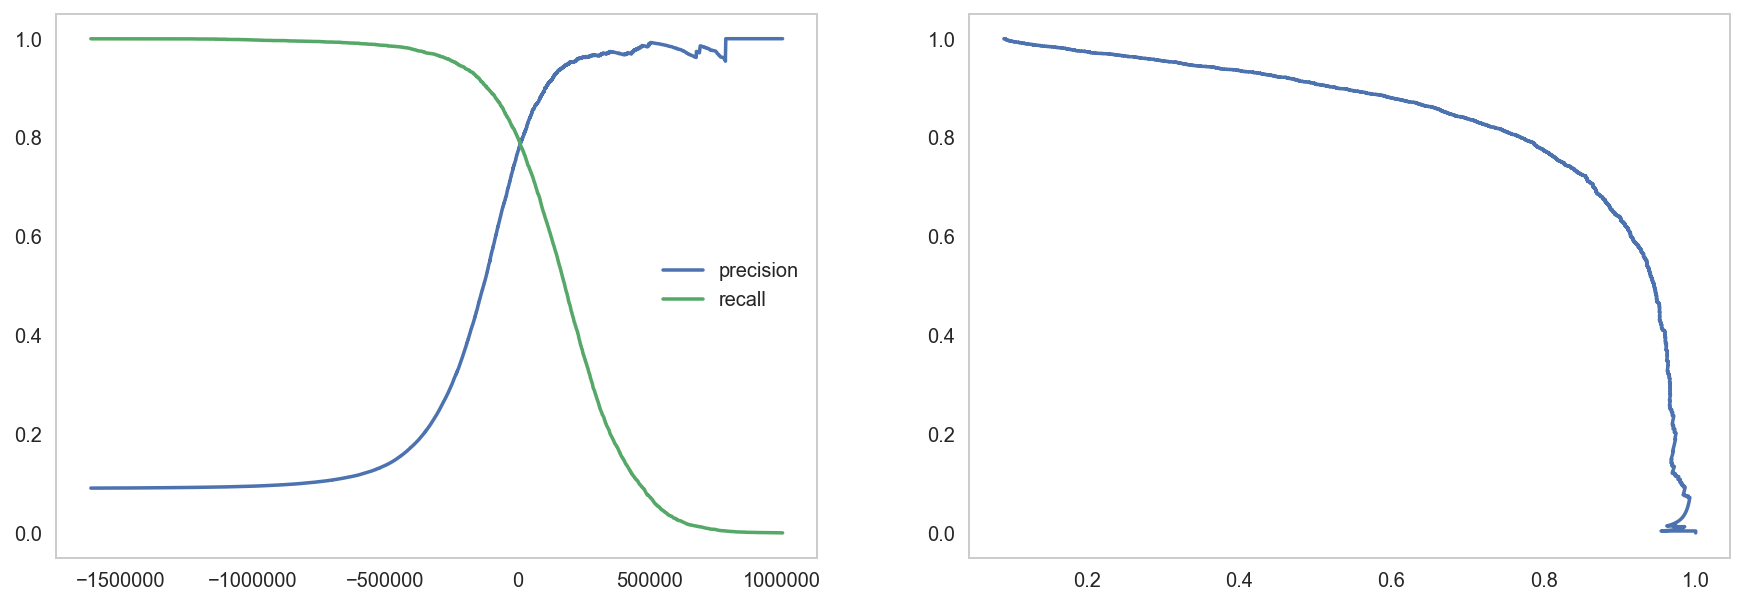

In [32]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(thresholds, precisions[:-1], label='precision')
plt.plot(thresholds, recalls[:-1], label='recall')
plt.legend()
plt.grid(False)

plt.subplot(122)
plt.plot(precisions, recalls)
plt.grid(False);

In [33]:
res = []
for th in np.linspace(-1000000, 1000000, 10000):
    r = (y_scores > th)
    
    rr = y_train_5[r==True].astype(int)
    rr = np.sum(rr)/len(rr)
    
    pr = r[y_train_5==True].astype(int)
    pr = np.sum(pr)/len(pr)
    
    res.append([rr, pr])
res = np.array(res)

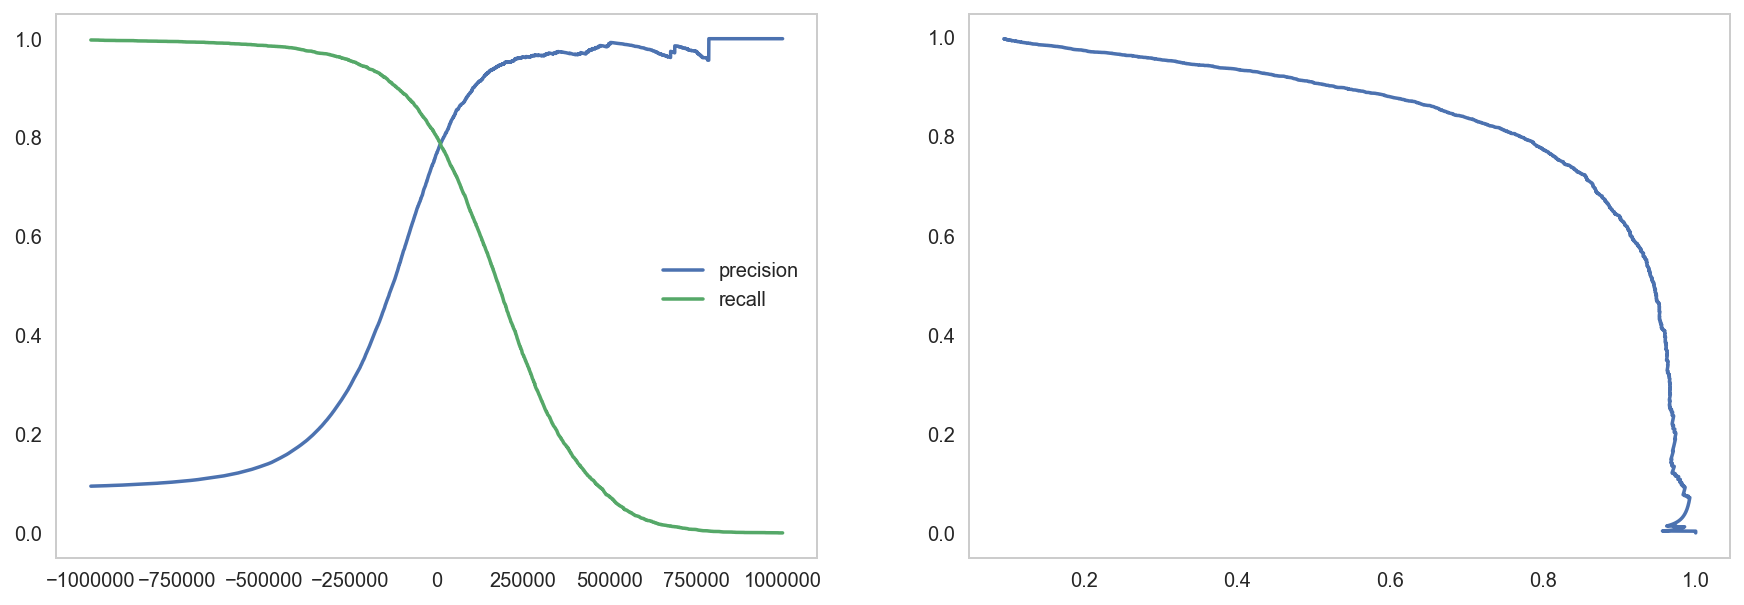

In [34]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(np.linspace(-1000000, 1000000, 10000), res[:,0], label='precision')
plt.plot(np.linspace(-1000000, 1000000, 10000), res[:,1], label='recall')
plt.legend()
plt.grid(False)

plt.subplot(122)
plt.plot(res[:,0], res[:, 1])
plt.grid(False);

이제 작업에 맞는 최선의 정밀도/재현율 트레이드오프를 마드는 임계값을 선택하면됩니다.<br>
재현율 80% 근처에서 정밀도가 급격하게 줄어들기 시작합니다.<br>
이 하강점 직전을 정밀도/재현율 트레이드오프로 선택하는 것이 좋습니다.<br>

정밀도 90%를 달성하는 것이 목표라고 가정해봅시다. 임계값 70000정도라는 것을 알 수 있습니다.

In [35]:
y_train_pred_90 = (y_scores > 70000)

In [36]:
precision_score(y_train_5, y_train_pred_90)

0.8659205116491548

In [37]:
recall_score(y_train_5, y_train_pred_90)

0.6993174691016417

### 3.3.5 ROC곡선

**수신기 조작 특성**(ROC) 곡선도 이진 분류에서 널리 사용하는 도구입니다. <br>
정밀도/재현율 곡선과 매우 비슷하지만, ROC 곡선은 정밀도에 대한 재현율 곡선이 아니고 거짓 양성 비율(FPR)에 대한 진짜 양성비율(TPR)의 곡선입니다.<br>

In [63]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

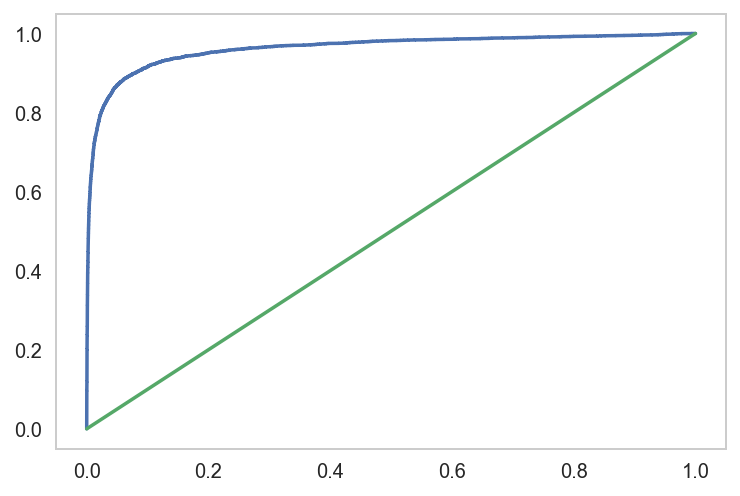

In [64]:
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1])
plt.grid(False);

In [40]:
score_idx = np.argsort(y_scores)[::-1] # 정렬하고 양수부터

In [41]:
ys = y_scores[score_idx][::20]
yh = y_train_5[score_idx][::20]

res = []
for t in ys:
    r = ys < t
    
    tpr = r[yh==True].astype(int)
    tpr = sum(tpr)/len(tpr)
    
    fpr = r[yh==False].astype(int)
    fpr = (sum(fpr)/len(fpr))

    res.append([tpr, fpr])

res = np.array(res)

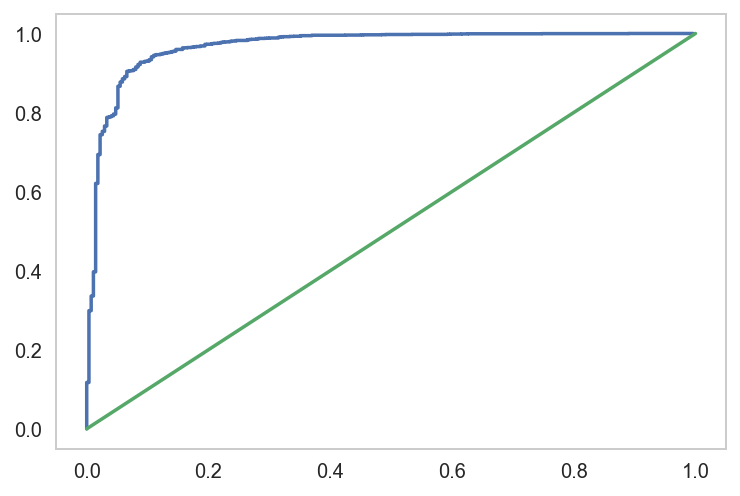

In [43]:
plt.plot(res[:,0], res[:, 1])
plt.plot([0,1],[0,1])
plt.grid(False);

재현율(TPR)이 높을수록 분류기가 만드는 거짓 양성 FPR이 늘어납니다.<br>

곡선 아래의 면적(AUC)를 측정하면 분류기들을 비교할 수 있습니다.

In [45]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9624496555967155

In [53]:
from sklearn.metrics import auc
auc(res[:,0], res[:, 1])

0.9646970802086313

In [59]:
1 + np.trapz(res[:, 0], res[:,1])

0.9683600838716351

RandomForestClassifier를 훈련시켜 SGDClassifier의 ROC 곡선과 ROC AUC점수를 비교해보겠습니다<br>

In [60]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

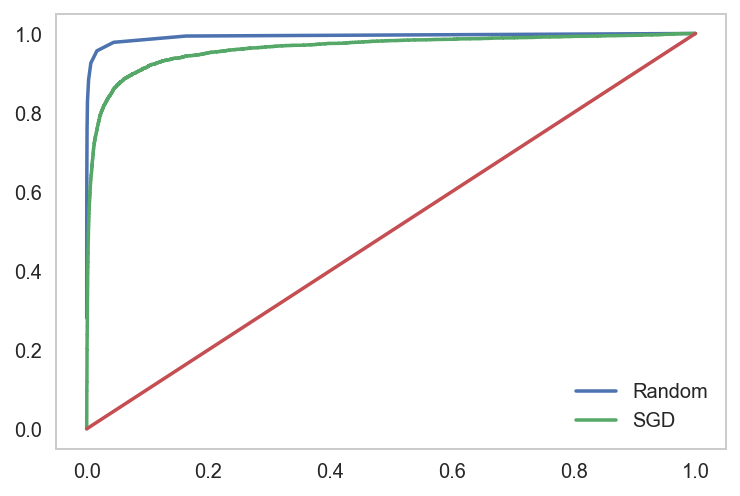

In [67]:
plt.plot(fpr_forest, tpr_forest, label='Random')
plt.plot(fpr, tpr, label='SGD')
plt.plot([0,1],[0,1])
plt.legend()
plt.grid(False);

In [70]:
roc_auc_score(y_train_5, y_scores_forest), roc_auc_score(y_train_5, y_scores)

(0.9931243366003829, 0.9624496555967155)

In [74]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9852973447443494

In [76]:
recall_score(y_train_5, y_train_pred_forest)

0.8282604685482383

## 3.4 다중 분류기

랜덤포레스트 분류기, 나이브베이즈 분류기는 다중 분류 가능합니다. 반면 SVM같은 선형분류기는 이진분류만 가능합니다.<br>
하지만 이진 분류기를 여러개 사용하여 다중분류가 가능합니다.

일대다 OvA 전략 : 숫자 하나만 구분하는 수자별 이진분류기 10개를 훈련시켜 클래스가 10개인 숫자 이미지 분류 시스템을 만들 수 있습니다.<br>
이미지를 분류 할때 각 분류기이 결정 점수 중에서 가장 높은 것을 클래스로 선택하면 됩니다.

일대일 OvO 전략 : 0과 1구별, 0과 2구별, 1과 2구별 등과 같이 각 숫자의 조합마다 이진분류기를 훈련시키는 것입니다.<br>
클래스가 N개라면 분류기는 N*(N-1)/2 개가 필요합니다. <br>
MNIST의 경우 45개의 분류기가 필요하며 45개 분류기를 모두 통과시켜 가장 많이 양성으로 분류된 클래스를 선택합니다.<br>
주요 장점은 전체 데이터중 구별할 두 클래스에 해당하는 샘플만 필요로 한다는 것입니다.

SVM알고리즘은 훈련 세트의 크기에 민감하므로 작은 훈련 세트에서 많은 분류기를 훈련시키는 쪽이 빠르므로 OvO를 선호합니다.<br>
그러나 대부분의 이진 분류 알고리즘에서 OvA를 선호합니다.

다중 클래스 분류 작업에 이진 분류 알고리즘을 선택하면 자동으로 OvA를 적용합니다.(SVM은 OvO가 기본값입니다.)<br>
SGDClassifier에 적용해보겠습니다.

In [85]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5.])

내부에서는 실제로 10개의 이진 분류기를 훈련시키고 각각의 결정 점수를 얻어 점수가 가장 높은 클래스를 선택합니다.<br>
확인을 위해 decision_function()를 호출합니다. 클래스마다의 점수를 반환합니다.

In [86]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-311402.62954431, -363517.28355739, -446449.5306454 ,
        -183226.61023518, -414337.15339485,  161855.74572176,
        -452576.39616343, -471957.14962573, -518542.33997148,
        -536774.63961222]])

In [87]:
sgd_clf.classes_[np.argmax(some_digit_scores)]

5.0

OvO나 OvA를 선택하여 사용하려면 OnevsOneClassifier난 OneVsRestClassifier를 사용합니다.<br>
이진분류기 인스턴스를 만들어 생성자에 전달하면 됩니다.

In [88]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5.])

In [89]:
len(ovo_clf.estimators_)

45

랜덤포레스트 분류기는 직접 샘플을 다중 클래스로 분류할 수 있기 때문에 별도로 OvO, OvA를 적용할 필요가 없습니다.<br>
predict_proba()를 사용하여 클래스별 확률을 확인할 수 있습니다.

In [101]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5.])

In [102]:
forest_clf.predict_proba([some_digit])

array([[0.1, 0. , 0. , 0.1, 0. , 0.8, 0. , 0. , 0. , 0. ]])

분류기 평가에는 일반적으로 교차 검증을 사용합니다.<br>
cross_val_score를 사용하여 SGDClassifier를 평가합니다.

In [90]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.84063187, 0.84899245, 0.86652998])

84%이상의 성능을 얻었습니다. 스케일을 조정하여 정확도를 높여보겠습니다.

In [91]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64)) # 평균을 0으로 조정
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.91011798, 0.90874544, 0.906636  ])

## 3.5 에러분석

모델의 성능을 향상시킬 방법으로 에러의 종류를 분석하는 것입니다.<br>
오차행렬을 살펴봅니다. cross_val_predict()사용하여 예측을 만들고 confusion_matrix를 호출합니다.

In [107]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5725,    3,   24,    9,   10,   49,   50,   10,   39,    4],
       [   2, 6493,   43,   25,    7,   40,    5,   10,  109,    8],
       [  51,   41, 5321,  104,   89,   26,   87,   60,  166,   13],
       [  47,   46,  141, 5342,    1,  231,   40,   50,  141,   92],
       [  19,   29,   41,   10, 5366,    9,   56,   37,   86,  189],
       [  73,   45,   36,  193,   64, 4582,  111,   30,  193,   94],
       [  29,   34,   44,    2,   42,   85, 5627,   10,   45,    0],
       [  25,   24,   74,   32,   54,   12,    6, 5787,   15,  236],
       [  52,  161,   73,  156,   10,  163,   61,   25, 5027,  123],
       [  43,   35,   26,   92,  178,   28,    2,  223,   82, 5240]])

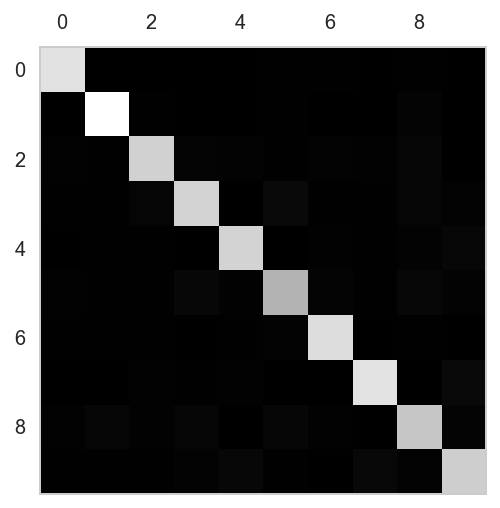

In [108]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.grid(False);

대부분의 이미지가 올바르게 분류되었음을 나타냅니다.
그래프의 에러 부분에 초점을 맞춰보겠습니다. 에러의 비율을 비교합니다.

In [114]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

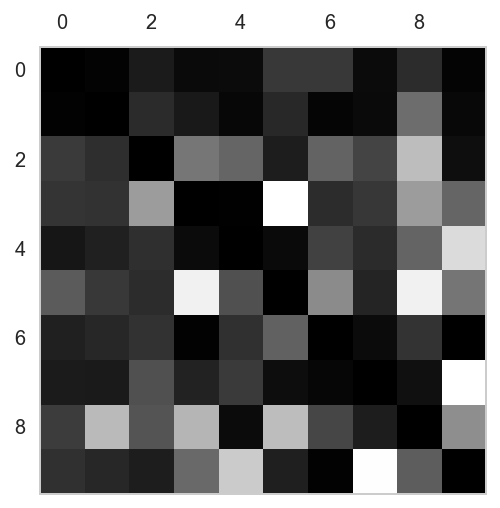

In [116]:
np.fill_diagonal(norm_conf_mx, 0 )
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.grid();

행은 실제 클래스를 나타내고 열은 예측한 클래스를 나타냅니다.<br>
8, 9의 영일 상당히 밝으므로 많은 이미지가 8과 9로 잘못 분류되었음을 알려줍니다. 마찬가지로 8과 9도 다른 숫자로 잘못 분류되고 있음을 알 수 있습니다.<br>

오차행렬을 분석하면 분류기의 성능 향상 방안에 대한 통찰을 얻을 수 있습니다.<br>
3과 5가 서로 혼돈되는 것, 8과 9를 더 잘 분류하도록 하는 것을 개선할 필요가 있어보입니다.<br>
훈련 데이터를 더 모으거나 분류기에 도움을 줄 특성을 추가합니다. 동심원의 수를 알려주는 알고리즘일 수 있습니다.<br>

In [138]:
# 숫자 그림을 위한 추가 함수
import matplotlib
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

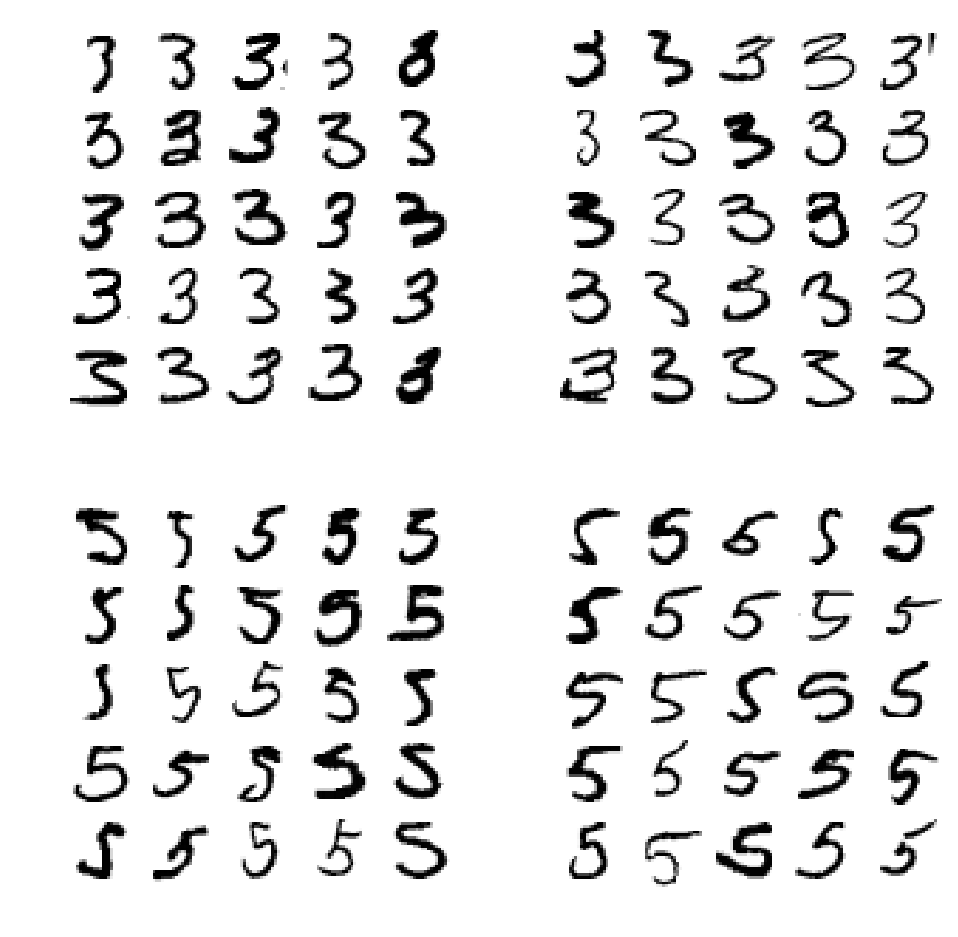

In [139]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)] # 3인데 3으로 예측한
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)] # 3인데 5라고 예측한
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)] # 5인데 3으로 예측한
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)] # 5인데 5라고 예측한

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

대부분의 잘못 분류된 이미지는 확실히 에러라 보입니다. 분류기가 실수한 이유를 이해하기 어렵습니다.<br>
원인은 SGDClassifier를 사용했기 때문입니다. 픽셀에 가중치를 할당하고 새로운 이미지에 대해 단순히 픿ㄹ 강도의 가중치 합을 클래스의 점수로 계산합니다.<br>
3과 5는 몇개의 픽셀만 다르기 때문에 모델이 쉽게 혼동하게 됩니다.

## 3.6 다중 레이블 분류

얼굴 인식 분류기는 같은 사진에 여러 사람이 등장한다면 인식된 사람마다 레이블을 하나씩 할당해야 합니다.<br>
분류기가 앨리스, 밥, 찰리 세 얼굴을 인식하도록 훈련되었다고 가정해봅시다.<br>
한 사진에 앨리스와 찰리가 있으면 분류기는 [1, 0, 1]을 출력해야합니다.

In [124]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7) # 7보다크고
y_train_odd = (y_train % 2 == 1) # 홀수 
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [126]:
knn_clf.predict([some_digit])

array([[False,  True]])

7보다 크지않고 홀수입니다. 잘 분류 되었습니다. 

다중 레이블 분류기를 평가하는 방법은 많습니다. 각 레이블의 $F_1$점수를 구하고 간단하게 평균 점수를 구합니다.<br>
모든 레이블에 대한 $F_1$점수의 평균을 계산합니다. 모든 레이블의 가중치가 같다고 가정한 것입니다.<br>
앨리스의 사진이 밥이나 찰리 사진보다 훨씬 많다면 앨리스 사진에 대한 분류기의 점수에 더 높은 가중치를 둘 것입니다.<br>
간단한 방법은 레이블에 클래스의 지지도(타겟 레이블에 속한 샘플수)를 가중치로 설정하는 것입니다.<br>
이진코드에서 average='weighted'로 설정하면 됩니다.

In [73]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=-1)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.97709078477525

## 3.7 다중 출력 분류

다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화한 것입니다.

이미지에서 노이즈를 제거하는 시스템을 만들어보겠습니다.<br>
노이즈이미지를 입력으로, 깨끗한 숫자 이미지를 배열로 출력합니다.<br>

분류기의 출력이 다중 레이블이고 각 레이블은 여러개의 값을 가집니다(0~255)그러기에 이 예는 다중 출력 분류 시스템입니다.

In [140]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [141]:
import random as rnd

In [142]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise

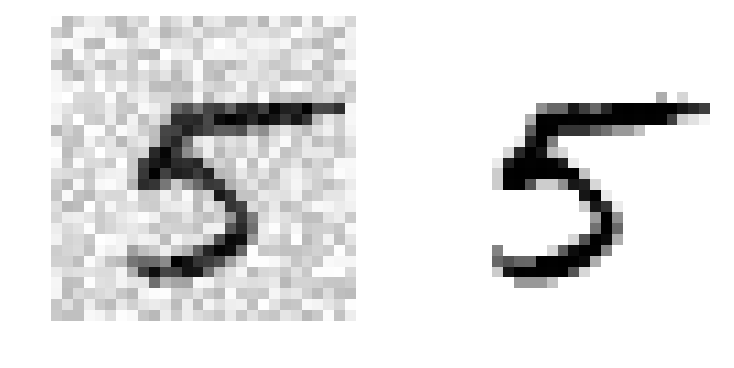

In [143]:
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

In [131]:
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

In [132]:
y_train_mod = X_train
y_test_mod = X_test
knn_clf.fit(X_train_mod, y_train_mod)

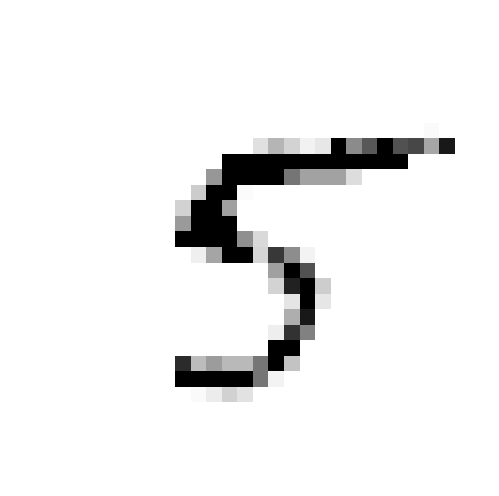

In [152]:
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

## 3.8 연습문제

1.MNIST 데이터넷으로 분류기를 만들어 테스트 세트에서 97% 정확도를 달성해보세요.<br>
KNeighborsClassifier가 이 작업에 아주 잘 맞습니다. 좋은 하이퍼파라미터 값만 찾으면 됩니다.

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [42]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3, n_jobs=-1)

In [89]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] n_neighbors=3, weights=uniform ..................................
[CV] n_neighbors=3, weights=uniform ..................................
[CV] n_neighbors=3, weights=uniform ..................................
[CV] n_neighbors=3, weights=uniform ..................................
[CV]  n_neighbors=3, weights=uniform, score=0.9714214297617064, total=12.0min
[CV] n_neighbors=3, weights=uniform ..................................
[CV]  n_neighbors=3, weights=uniform, score=0.9698458975426906, total=12.0min
[CV] n_neighbors=3, weights=distance .................................
[CV]  n_neighbors=3, weights=uniform, score=0.9728265399683255, total=12.0min
[CV] n_neighbors=3, weights=distance .................................
[CV]  n_neighbors=3, weights=uniform, score=0.9726666666666667, total=12.0min
[CV] n_neighbors=3, weights=distance .................................
[CV]  n_neighbors=3, weights=distance, score=0.9712619741774

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 466.1min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'n_neighbors': [3, 4, 5], 'weights': ['uniform', 'distance']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [90]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [91]:
grid_search.best_score_

0.97325

In [92]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.9714

2.MNIST 이미지를 (왼, 오른, 위, 아래) 어느 방향으로든 한 픽셀 이동시킬 수 있는 함수를 만들어보세요.<br>
그런 다음 훈련 세트에 있는 각 이미지에 대해 네 개의 이동된 복사본을 만들어 훈련 세트에 추가하세요.<br>
마지막으로 이 확장된 데이터넷에서 앞에서 찾은 최선의 모델을 훈련시키고 테스트 세트에서 정확도를 측정해보세요.<br>
모델 성능이 더 높아졌는지 확인해보세요. 인위적으로 훈련세트를 늘리는 이 기법을 테이터 증식또는 훈련 세트 확장이라고 합니다.

In [43]:
from scipy.ndimage.interpolation import shift

In [44]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

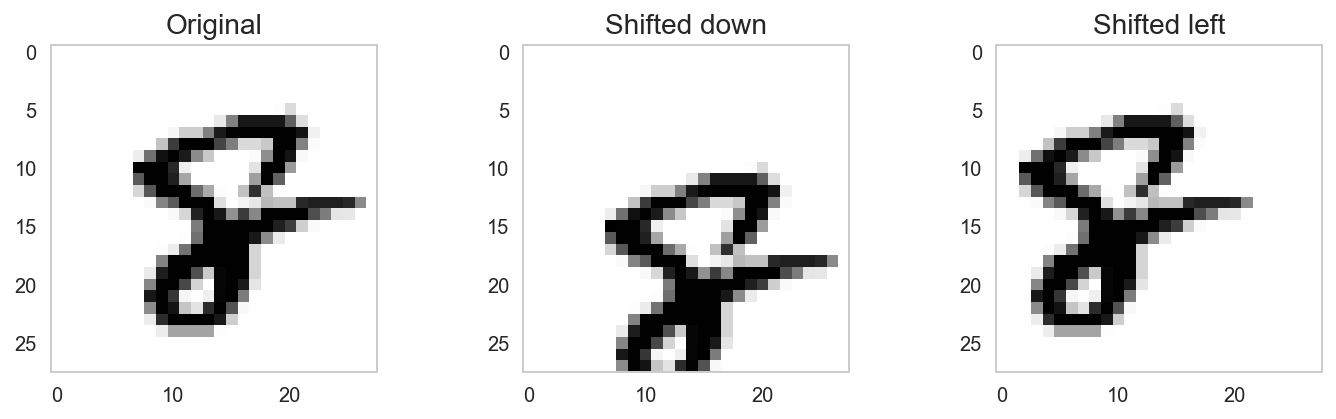

In [47]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.grid()
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.grid()
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.grid()
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [ ]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [48]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

In [50]:
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)
        
X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [51]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [56]:
knn_clf = KNeighborsClassifier(n_neighbors=4, weights='distance')

In [99]:
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='distance')

In [100]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9763